# Getting Started: Sensitivity Analysis

To start analyzing tree diversity, it's important to check if how sensistive your dataset is to the number of trees in the city center geographic boundary. The two diversity (entropy) indices used below are both impacted by the number of members in a sample, so this notebook walks through some basic cleaning and then iterates through counts of trees to generate plots suggested where the diversity indices reach a reasonable equilibrium.  

In [178]:
# library import
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import descartes
from tqdm import tqdm
import treeParsing as tP

# Import Tree Inventory and City Center Boundary

Import your tree data and city center boundary data below. These data may use any geospatial data format (SHP, Geojson, Geopackage) and should be in the same coordinate projection.

Your tree data will need the following columns:
* Point geographic location
* Diameter breast height (DBH)
* Tree Scientific Name
* Tree Genus Name
* Tree Family Name

Your city center geography simply needs to be a single, dissolved geometry representing your city center area.

In [183]:
### Enter the path to your data below ###
tree_data_path = 'example_data/trees_paris.gpkg'
tree_data = gpd.read_file(tree_data_path)

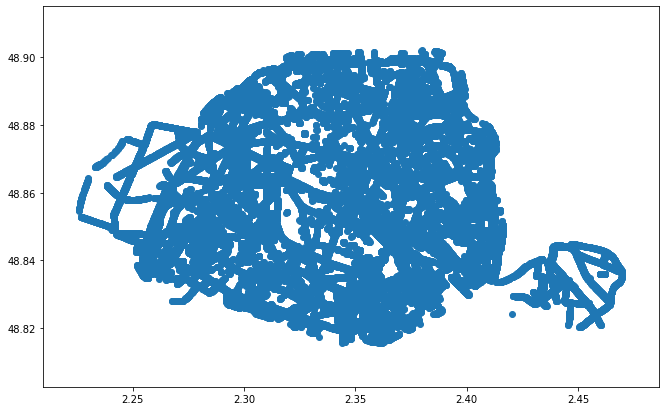

In [184]:
tree_data.plot()

In [185]:
### Enter the path to your data below ###
city_center_boundary_path = 'example_data/paris.gpkg'
city_center = gpd.read_file(city_center_boundary_path)

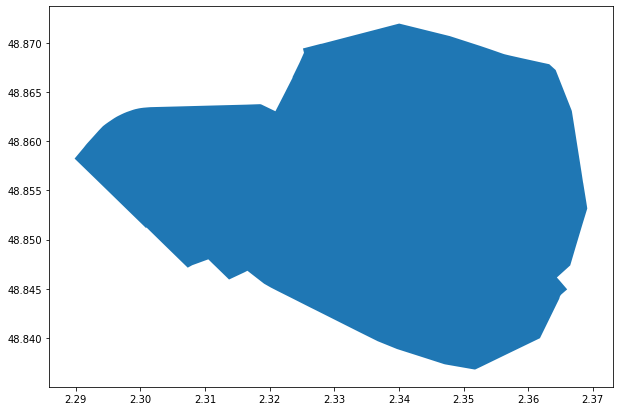

In [186]:
city_center.plot()

# Clean Data and Calculate Basal Area

To start, we need to remove features missing data and remove the top quantile of data. Removing any missing data and the top quantile helps remove erroneous entries that are too large or too small than what we would expect. If your data has already been cleaned, feel free to skip the second cell below.

In [188]:
### Enter your column names here ###
scientific_name_column = 'Scientific'
genus_name_column = 'genus'
family_name_column = 'family'
diameter_breast_height_column = 'DBH'

In [189]:
### Ignore if data is already cleaned ###
# Exclude Data Missing DBH
tree_data = tree_data[tree_data[diameter_breast_height_column]>0]

# Exclude data larger than the 99th quantile (often erroneously large)
tree_data = tree_data[tree_data[diameter_breast_height_column]<=tree_data.quantile(0.99).DBH]

In [190]:
# Calculate Basal Area
basal_area_column =  'BA'
tree_data[basal_area_column] = tree_data[diameter_breast_height_column]**2 * 0.00007854

# Generate Shannon and Simpson Indices for Count and Basal Area

This analysis will sample a random number of trees up to your total number of trees. By default, it will take 10 samples at each count, but a higher number will yield more accurate results.

In [192]:
### For more accurate results increase the iterations_per_count
### If this notebook is running too slowly on your computer, reduce the iterations_per_count
iterations_per_count = 10
increment_exponent = 1.01

In [193]:
# Generate counts for Sample Size
i = 1
sample_size_list = []

while i < len(tree_data):
    sample_size_list.append(round(i))   
    i = (i+1)**increment_exponent
sample_size_list.append(len(tree_data))

# List of results
entropy_data = []

# Loop through increasing sizes of tree samples until you hit the size of the tree data
for count in tqdm(sample_size_list):    
    # Repeat for the number of iterations
    for i in range(0,iterations_per_count):
        # Sample the trees
        sample = tree_data.sample(count)
        
        # Derive counts, areas, for species, genus, and family
        species_count = sample[[scientific_name_column, basal_area_column]].groupby(scientific_name_column).count().reset_index()
        species_area = sample[[scientific_name_column, basal_area_column]].groupby(scientific_name_column).sum().reset_index()
        
        genus_count = sample[[genus_name_column, basal_area_column]].groupby(genus_name_column).count().reset_index()
        genus_area = sample[[genus_name_column, basal_area_column]].groupby(genus_name_column).sum().reset_index()
        
        family_count = sample[[family_name_column, basal_area_column]].groupby(family_name_column).count().reset_index()
        family_area = sample[[family_name_column, basal_area_column]].groupby(family_name_column).sum().reset_index()
        
        
        # Calculate Percentages by count and area
        species_count["Pct"] = species_count[basal_area_column]/sum(species_count[basal_area_column])
        species_area["Pct"]  = species_area[basal_area_column]/sum(species_area[basal_area_column])
        
        genus_count["Pct"] = genus_count[basal_area_column]/sum(genus_count[basal_area_column])
        genus_area["Pct"] = genus_area[basal_area_column]/sum(genus_area[basal_area_column])
        
        family_count["Pct"] = family_count[basal_area_column]/sum(family_count[basal_area_column])
        family_area["Pct"] = family_area[basal_area_column]/sum(family_area[basal_area_column])
        
        # Calculate Shannon Indices
        species_shannon_count = tP.ShannonEntropy(list(species_count["Pct"]))
        species_shannon_area = tP.ShannonEntropy(list(species_area["Pct"]))
        
        genus_shannon_count = tP.ShannonEntropy(list(genus_count["Pct"]))
        genus_shannon_area = tP.ShannonEntropy(list(genus_area["Pct"]))
        
        family_shannon_count = tP.ShannonEntropy(list(family_count["Pct"]))
        family_shannon_area = tP.ShannonEntropy(list(family_area["Pct"]))
        
        # Calculate Simpson Indices
        species_simpson_count = tP.simpson_di(list(species_count[scientific_name_column]), list(species_count[basal_area_column]))
        species_simpson_area = tP.simpson_di(list(species_area[scientific_name_column]),list(species_area[basal_area_column]))
        
        genus_simpson_count = tP.simpson_di(list(genus_count[genus_name_column]), list(genus_count[basal_area_column]))
        genus_simpson_area = tP.simpson_di(list(genus_area[genus_name_column]), list(genus_area[basal_area_column]))
        
        family_simpson_count = tP.simpson_di(list(family_count[family_name_column]), list(family_count[basal_area_column]))
        family_simpson_area = tP.simpson_di(list(family_area[family_name_column]), list(family_area[basal_area_column]))
        
        # Append to results
        entropy_data.append({
            'count': count,
            'species_simpson_count': species_simpson_count,
            'species_simpson_area': species_simpson_area,
            'genus_simpson_count': genus_simpson_count,
            'genus_simpson_area': genus_simpson_area,
            'family_simpson_count': family_simpson_count,
            'family_simpson_area': family_simpson_area,
            'species_shannon_count': species_shannon_count,
            'species_shannon_area': species_shannon_area,
            'genus_shannon_count': genus_shannon_count,
            'genus_shannon_area': genus_shannon_area,
            'family_shannon_count': family_shannon_count,
            'family_shannon_area': family_shannon_area
        })
        
# Load results into a Dataframe and get median vlalues
results_df = pd.DataFrame(entropy_data)
median_df = results_df.groupby('count').median().reset_index()
median_df.head()

100%|████████████████████████████████████████████████████████████████████████████████| 132/132 [00:59<00:00,  2.21it/s]


,count,species_simpson_count,species_simpson_area,genus_simpson_count,genus_simpson_area,family_simpson_count,family_simpson_area,species_shannon_count,species_shannon_area,genus_shannon_count,genus_shannon_area,family_shannon_count,family_shannon_area
0,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000
1,2,0.500000,0.375788,0.500000,0.375788,0.500000,0.375788,0.693147,0.563199,0.693147,0.563199,0.693147,0.563199
2,3,0.666667,0.508233,0.666667,0.508233,0.666667,0.508233,1.098612,0.766421,1.098612,0.766421,1.098612,0.766421
3,4,0.687500,0.462771,0.625000,0.462771,0.625000,0.462771,1.213008,0.714235,1.039721,0.714235,1.039721,0.714235
4,5,0.760000,0.557136,0.720000,0.554082,0.720000,0.554082,1.470808,0.963328,1.332179,0.893326,1.332179,0.893326


# Chart Shannon Index by Basal Area

Our results are now loaded into a DataFrame. The below functions and cells will map out each combination (Shannon Index and Simpson Index by Area and Count). Each plot will include a vertical line indicating the count of trees in your tree inventory contained within your city center geography. If the vertical line falls after the slope of the species, genus, and family lines have leveled off, it is reasonable to continueto the second notebook, which conducts the analysis. 

In [194]:
city_center_tree_count = len(gpd.sjoin(tree_data, city_center))
plt.rcParams["figure.figsize"] = [14, 7]

In [195]:
def generateFigure(df, index, measure):
    x = df['count']
    y = df[f'species_{index}_{measure}']
    y2 = df[f'genus_{index}_{measure}']
    y3 = df[f'family_{index}_{measure}']

    axes = plt.gca()
    axes.set_xlim([1,city_center_tree_count*4])
    
    if index == "shannon":
        axes.set_ylim([0,4.5])
    else: 
        axes.set_ylim([0,1])
        
    plt.xscale('symlog')
    plt.xlabel('Random Sample Size (Log Scale)')

    plt.ylabel(f'{index.capitalize()} Index ({measure.capitalize()})')

    plt.scatter(x, y, s=30, c='red', alpha=1, marker="x", label='Species')
    plt.scatter(x, y2, s=30, c='orange', alpha=1, marker="+", label='Genus')
    plt.scatter(x, y3, s=30, c='green', alpha=1, marker="_", label='Family')
    plt.legend(loc="upper left")

    plt.axvline(x=city_center_tree_count, linewidth=1, color='black')
    plt.text(city_center_tree_count+1000,0.1,'Trees in City Center',horizontalalignment='left', rotation=90)

    plt.title(f'{index.capitalize()} Index by {measure.capitalize()}')
    plt.show()

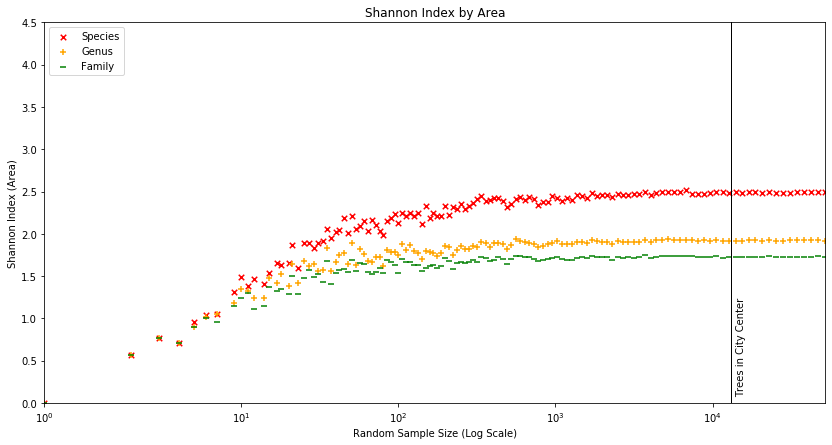

In [196]:
generateFigure(median_df, 'shannon', 'area')

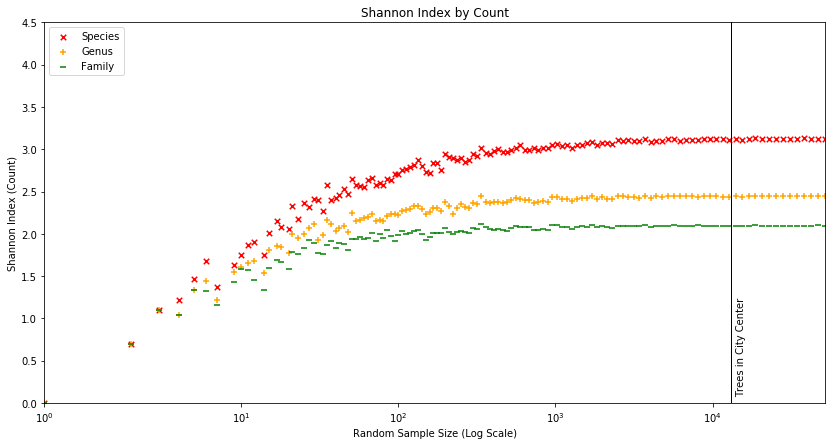

In [197]:
generateFigure(median_df, 'shannon', 'count')

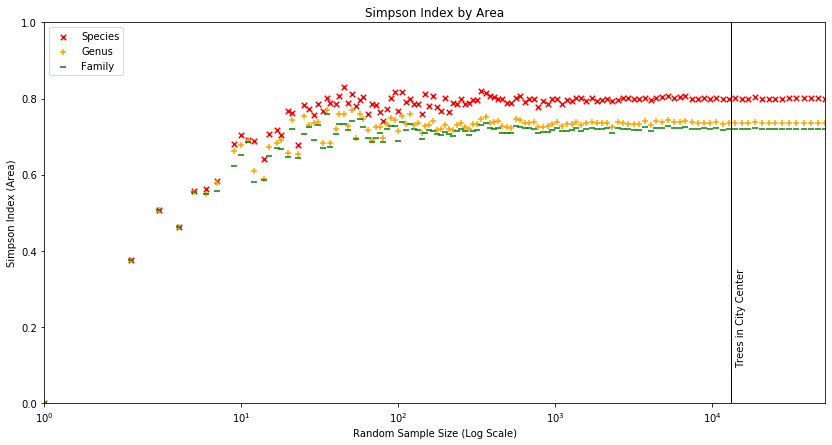

In [198]:
generateFigure(median_df, 'simpson', 'area')

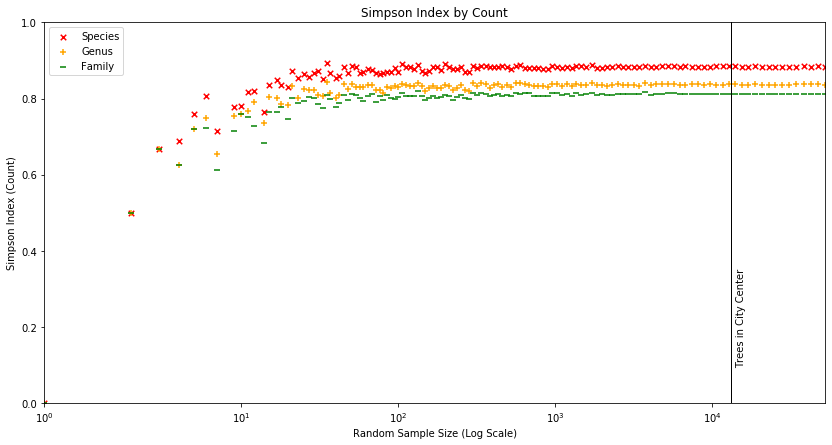

In [199]:
generateFigure(median_df, 'simpson', 'count')

___

All looks good? Continue to Notebook 2: City Center Diversity Analysis